In [1]:

# set the matplotlib backend so figures can be saved in the background
import matplotlib
#matplotlib.use("Agg")
from glob import glob 

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from pyimagesearch.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np 
import pandas as pd  
import argparse
import random
import pickle
import cv2
import os 
import heapq
import shutil   
import ipyplot 

# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os



Using TensorFlow backend.


In [2]:


class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes, finalAct="softmax"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation(finalAct))

		# return the constructed network architecture
		return model

In [3]:
dataset1 = "../dataset" # ="path to input dataset (i.e., directory of images)")
model1 = "fashion.model" # ="path to output model")
labelbin1 = "mlb.pickle"  # ="path to output label binarizer")
plot1 = "plot.png" # "path to output accuracy/loss plot")


In [4]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 16 # 3 # 16 # 75
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)


In [5]:

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(dataset1)))
random.seed(42)
random.shuffle(imagePaths)


[INFO] loading images...


In [6]:
# initialize the data and labels
data = []
labels = []


In [7]:

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = img_to_array(image)
	data.append(image)

	# extract set of class labels from the image path and update the
	# labels list
	l = label = imagePath.split(os.path.sep)[-2].split("_")
	labels.append(l)


In [8]:

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(imagePaths), data.nbytes / (1024 * 1000.0)))


[INFO] data matrix: 2165 images (467.64MB)


In [9]:

# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)


[INFO] class labels:


In [10]:

# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))


1. black
2. blue
3. dress
4. jeans
5. red
6. shirt


In [11]:

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)


In [12]:

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")


In [13]:

# initialize the model using a sigmoid activation as the final layer
# in the network so we can perform multi-label classification
print("[INFO] compiling model...")
model = SmallerVGGNet.build(
	width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
	finalAct="sigmoid")


[INFO] compiling model...


In [14]:
# initialize the optimizer (SGD is sufficient)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)


In [15]:

# compile the model using binary cross-entropy rather than
# categorical cross-entropy -- this may seem counterintuitive for
# multi-label classification, but keep in mind that the goal here
# is to treat each output label as an independent Bernoulli
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


In [16]:

# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)


[INFO] training network...
Epoch 1/16
54/54 [==============================] - 199s 4s/step - loss: 0.3543 - accuracy: 0.8598 - val_loss: 1.2431 - val_accuracy: 0.6721
Epoch 2/16
54/54 [==============================] - 168s 3s/step - loss: 0.2041 - accuracy: 0.9257 - val_loss: 1.6422 - val_accuracy: 0.6424
Epoch 3/16
54/54 [==============================] - 170s 3s/step - loss: 0.1636 - accuracy: 0.9448 - val_loss: 1.6417 - val_accuracy: 0.6259
Epoch 4/16
54/54 [==============================] - 169s 3s/step - loss: 0.1358 - accuracy: 0.9516 - val_loss: 0.8541 - val_accuracy: 0.7279
Epoch 5/16
54/54 [==============================] - 166s 3s/step - loss: 0.1166 - accuracy: 0.9560 - val_loss: 1.2355 - val_accuracy: 0.7352
Epoch 6/16
54/54 [==============================] - 166s 3s/step - loss: 0.1298 - accuracy: 0.9589 - val_loss: 0.3693 - val_accuracy: 0.8953
Epoch 7/16
54/54 [==============================] - 166s 3s/step - loss: 0.1344 - accuracy: 0.9517 - val_loss: 0.2232 - val_acc

In [17]:
# save the model to disk
print("[INFO] serializing network...")
model.save(model1)


[INFO] serializing network...


In [18]:
# save the multi-label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open(labelbin1, "wb")
f.write(pickle.dumps(mlb))
f.close()


[INFO] serializing label binarizer...


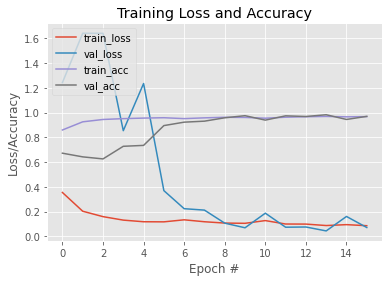

In [19]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig(plot1)
plt.show()

# Prediction 

In [2]:
# USAGE
model2 = "fashion.model" # path to trained model model 
labelbin2 = "mlb.pickle" # path to label binarizer 
path_to_classfication_images = "pics/"
#image2 = "../examples/example_01.jpg" # path to input image 


In [3]:
# load the trained convolutional neural network and the multi-label
# binarizer
print("[INFO] loading network...")
model = load_model(model2)
mlb = pickle.loads(open(labelbin2, "rb").read())


[INFO] loading network...


In [4]:
image_file_path_collection = glob(path_to_classfication_images+"/**")
print(image_file_path_collection)

['pics\\4xl-black-gown-pavitra-original-imafn9dh5hpdhq2w.jpeg', 'pics\\free-hm-kash-1023-m-s-retail-original-imafh9cvkghrphwc.jpeg', 'pics\\free-hm-kash-1023-m-s-retail-original-imafh9cvsq7hz2uy.jpeg', 'pics\\free-hm-kash-1023-m-s-retail-original-imafh9cvv8t4wycu.jpeg', 'pics\\free-sari-5-mithark-original-imafm5hgeyeehvtu.jpeg', 'pics\\free-sari-5-mithark-original-imafm5hgnhavxu3h.jpeg', 'pics\\free-sari-5-mithark-original-imafm5hgv3qwvaxh.jpeg', 'pics\\l-black-dori-pmd-fashion-original-imafn2rcyx4hqs4e.jpeg', 'pics\\l-rs19stkt-b-rope-original-imafeeuhmfuyzj7f.jpeg', 'pics\\l-rs19stkt-b-rope-original-imafeeuhwywtgzwy.jpeg', 'pics\\m-black-dori-pmd-fashion-original-imafn2rydq93dfky.jpeg', 'pics\\m-black-gown-pavitra-original-imafn9dhf4fs94gt.jpeg', 'pics\\m-pr343white-prakhya-original-imafj5awct4fryr7.jpeg', 'pics\\m-pr343white-prakhya-original-imafj5awhczfzwz3.jpeg', 'pics\\m-pr343white-prakhya-original-imafj5awnfunzpba.jpeg', 'pics\\m-pr343white-prakhya-original-imafj5awvx26z9hq.jpeg'

In [5]:
def build_path(directory):
    try:
        os.makedirs(directory)
    except: 
        pass


In [9]:
data_image = []
data_label = []
for image2 in image_file_path_collection:
    print("check of image at ", image2)
    # load the image
    image = cv2.imread(image2)
    output = imutils.resize(image, width=400)

    prediction_score = []
    label_of_score = []
    
    # pre-process the image for classification
    image = cv2.resize(image, (96, 96))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # classify the input image then find the indexes of the two class
    # labels with the *largest* probability
    print("[INFO] classifying image...")
    proba = model.predict(image)[0]
    idxs = np.argsort(proba)[::-1][:2]

    # loop over the indexes of the high confidence class labels
    for (i, j) in enumerate(idxs):
    	# build the label and draw the label on the image
    	label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
    	cv2.putText(output, label, (10, (i * 30) + 25), 
    		cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


    # show the probabilities for each of the individual labels
    for (label, p) in zip(mlb.classes_, proba):
        print(label,p)
        prediction_score.append(p)
        label_of_score.append(label)
    #	print("{}: {:.2f}%".format(label, p * 100))
    print(46*"/")
    data_dictionary = {"label":label_of_score, "prediction_score":prediction_score}
    print("data_dictionary = ", data_dictionary)
    print("df before sort . ")
    df = pd.DataFrame(data_dictionary) 
    print(df)
    print("df after sort . ")
    df = df.sort_values(by = "prediction_score", ascending = False)
    df = df.iloc[0:2,0:]
    print(df)
    df["label"] = df["label"].apply(lambda x: (str(x) + " "))
    directory = ""
    directory = df["label"].sum()
    label_processed = directory 
    directory = "pics_classification/" + directory + "/"
    directory = directory.strip()
    print(directory)
    build_path(directory)
    _, file1 = os.path.split(image2)
    shutil.copy(image2, directory+file1) 
    print("file\n", file1,"moved from\n",image2,"to\n",(directory+file1))
    print(46*"/")
    data_image.append(directory+file1)
    data_label.append(label_processed)
    # show the output image
    #cv2.imshow("Output", output)
    cv2.waitKey(0)    
    del image2, image, proba, idxs, label, p, directory, df, file1, output 
    
    

check of image at  pics\4xl-black-gown-pavitra-original-imafn9dh5hpdhq2w.jpeg
[INFO] classifying image...
black 0.0048513915
blue 0.80411845
dress 0.972098
jeans 0.005765514
red 0.06624848
shirt 0.014195777
//////////////////////////////////////////////
data_dictionary =  {'label': ['black', 'blue', 'dress', 'jeans', 'red', 'shirt'], 'prediction_score': [0.0048513915, 0.80411845, 0.972098, 0.005765514, 0.06624848, 0.014195777]}
df before sort . 
   label  prediction_score
0  black          0.004851
1   blue          0.804118
2  dress          0.972098
3  jeans          0.005766
4    red          0.066248
5  shirt          0.014196
df after sort . 
   label  prediction_score
2  dress          0.972098
1   blue          0.804118
pics_classification/dress blue /
file
 4xl-black-gown-pavitra-original-imafn9dh5hpdhq2w.jpeg moved from
 pics\4xl-black-gown-pavitra-original-imafn9dh5hpdhq2w.jpeg to
 pics_classification/dress blue /4xl-black-gown-pavitra-original-imafn9dh5hpdhq2w.jpeg
/////////

5  shirt          0.008479
df after sort . 
   label  prediction_score
2  dress          0.653665
3  jeans          0.532497
pics_classification/dress jeans /
file
 m-black-dori-pmd-fashion-original-imafn2rydq93dfky.jpeg moved from
 pics\m-black-dori-pmd-fashion-original-imafn2rydq93dfky.jpeg to
 pics_classification/dress jeans /m-black-dori-pmd-fashion-original-imafn2rydq93dfky.jpeg
//////////////////////////////////////////////
check of image at  pics\m-black-gown-pavitra-original-imafn9dhf4fs94gt.jpeg
[INFO] classifying image...
black 0.0011287766
blue 0.95147026
dress 0.9891298
jeans 0.0012412712
red 0.047373995
shirt 0.0035163055
//////////////////////////////////////////////
data_dictionary =  {'label': ['black', 'blue', 'dress', 'jeans', 'red', 'shirt'], 'prediction_score': [0.0011287766, 0.95147026, 0.9891298, 0.0012412712, 0.047373995, 0.0035163055]}
df before sort . 
   label  prediction_score
0  black          0.001129
1   blue          0.951470
2  dress          0.989130
3 

5  shirt          0.012457
df after sort . 
   label  prediction_score
2  dress          0.892553
1   blue          0.516331
pics_classification/dress blue /
file
 xxl-black-dori-pmd-fashion-original-imafn2rkut8uz4uz.jpeg moved from
 pics\xxl-black-dori-pmd-fashion-original-imafn2rkut8uz4uz.jpeg to
 pics_classification/dress blue /xxl-black-dori-pmd-fashion-original-imafn2rkut8uz4uz.jpeg
//////////////////////////////////////////////
check of image at  pics\xxl-black-gown-pavitra-original-imafn9dhjk9dayx5.jpeg
[INFO] classifying image...
black 0.000798687
blue 0.73369795
dress 0.98631614
jeans 0.0031684798
red 0.5176506
shirt 0.0064939586
//////////////////////////////////////////////
data_dictionary =  {'label': ['black', 'blue', 'dress', 'jeans', 'red', 'shirt'], 'prediction_score': [0.000798687, 0.73369795, 0.98631614, 0.0031684798, 0.5176506, 0.0064939586]}
df before sort . 
   label  prediction_score
0  black          0.000799
1   blue          0.733698
2  dress          0.986316


In [13]:
ipyplot.plot_class_tabs(np.array(data_image), np.array(data_label), img_width = 181)

In [15]:
print(6*" done ")

 done  done  done  done  done  done 
